In [1]:
from inference import PerphectInteractionModel, load_keras_weights, precompute_and_cache_sequences
from inference import encode_sequence_onehot, tensor_to_sequence
import numpy as np
import torch 
import pandas as pd
from inference import InteractionDataset

#model = PerphectInteractionModel()
#model = load_keras_weights(model, "./data/saved_model/model_v1.h5")

In [2]:
#torch.save(model.state_dict(), "./data/saved_model/model_v1.pth")

In [3]:
model = PerphectInteractionModel()
model.load_state_dict(torch.load("./data/saved_model/model_v1.pth", weights_only=True))

<All keys matched successfully>

In [4]:
# Load private data
bacteria_df = pd.read_csv("./data/private_data_set/bacteria_df.csv")
phages_df = pd.read_csv("./data/private_data_set/phages_df.csv")
couples_df = pd.read_csv("./data/private_data_set/couples_df.csv")

# Precompute one-hot encoded sequences and cache them
cache_dir = "./data/private_data_set/cached_tensors"
phage_paths_private, bacterium_paths_private = precompute_and_cache_sequences(phages_df, bacteria_df, cache_dir)

In [5]:
# Load data
bacteria_df = pd.read_csv("./data/public_data_set/bacteria_df.csv")
phages_df = pd.read_csv("./data/public_data_set/phages_df.csv")
couples_df = pd.read_csv("./data/public_data_set/couples_df.csv")

# Precompute one-hot encoded sequences and cache them
cache_dir = "./data/public_data_set/cached_tensors"
phage_paths_public, bacterium_paths_public = precompute_and_cache_sequences(phages_df, bacteria_df, cache_dir)

In [6]:
dataset = InteractionDataset(couples_df, phage_paths_public, bacterium_paths_public)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [30]:
from gradcam import GradCAM

# Constants for fixed input lengths
BACTERIUM_THRESHOLD = 7000000
PHAGE_THRESHOLD = 200000
idx = 123

bacterium_tensor, phage_tensor, label = dataset[idx]
bacterium_tensor = bacterium_tensor.unsqueeze(0)
phage_tensor = phage_tensor.unsqueeze(0)

bact_seq = tensor_to_sequence(bacterium_tensor)
phage_seq = tensor_to_sequence(phage_tensor)

input = (bacterium_tensor.requires_grad_(), phage_tensor.requires_grad_())
branch = "bacteria"
target_layer = model.bacteria_branch.conv3


In [32]:
from captum.attr import LayerGradCam as GradCam

gradcam = GradCam(model, target_layer)
attribution = gradcam.attribute(input)


BacterialBranch shape after conv3 torch.Size([1, 32, 279])
BacterialBranch shape after reshaping torch.Size([1, 8928])
PhageBranch shape after conv2 torch.Size([1, 32, 199])
PhageBranch shape after reshaping torch.Size([1, 6368])


In [34]:
from captum.attr import GuidedGradCam

guided_gradcam = GuidedGradCam(model, target_layer)
attribution_guided = guided_gradcam.attribute(input)[0] if branch is 'bacteria' else guided_gradcam.attribute(input)[1]

BacterialBranch shape after conv3 torch.Size([1, 32, 279])
BacterialBranch shape after reshaping torch.Size([1, 8928])
PhageBranch shape after conv2 torch.Size([1, 32, 199])
PhageBranch shape after reshaping torch.Size([1, 6368])


<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/7p/vsz_gnkx7sg_k1blv9xktznr0000gn/T/ipykernel_51954/2869248369.py:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  attribution_guided = guided_gradcam.attribute(input)[0] if branch is 'bacteria' else guided_gradcam.attribute(input)[1]
/Users/arthurbabey/miniconda3/envs/ML/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


BacterialBranch shape after conv3 torch.Size([1, 32, 279])
BacterialBranch shape after reshaping torch.Size([1, 8928])
PhageBranch shape after conv2 torch.Size([1, 32, 199])
PhageBranch shape after reshaping torch.Size([1, 6368])


In [35]:
attribution_guided.shape

torch.Size([1, 4, 7000000])

In [36]:
attribution.shape

torch.Size([1, 1, 558])

In [40]:
attribution_guided_scaled = combine_attributions(attribution_guided.detach())
attribution_guided_scaled.shape

(7000000,)

In [49]:
attribution_scaled = combine_attributions(attribution.detach(), input_length=7e6)
attribution_scaled.shape

(7000000,)

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Setting backward hooks on ReLU activations.")


In [57]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

def combine_attributions(attr_tensor, method='sum', input_length=None):

    if attr_tensor.dim() != 3:
        raise ValueError("Attribution tensor must have 3 dimensions (batch, channels, length)")
    
    batch, channels, length = attr_tensor.shape
    
    # Case 1: GuidedGradCam attribution with 4 channels (one per nucleotide)
    if channels == 4:
        attr = attr_tensor.squeeze(0)  # now shape is [4, L]
        if method == 'sum':
            combined = attr.sum(dim=0)
        elif method == 'max':
            combined, _ = attr.max(dim=0)
        else:
            raise ValueError("Unsupported method. Choose 'sum' or 'max'.")
        # Normalize to range [0, 1]
        combined = (combined - combined.min()) / (combined.max() - combined.min())
        return combined.cpu().numpy()
    
    # Case 2: LayerGradCam attribution with 1 channel (coarse feature map)
    elif channels == 1:
        if input_length is None:
            raise ValueError("For a single-channel attribution (LayerGradCam), you must provide input_length.")
        # Convert input_length to int and wrap it in a tuple
        target_size = (int(input_length),)
        # Upsample from current length (N) to input_length using nearest-neighbor interpolation
        upsampled = F.interpolate(attr_tensor, size=target_size, mode="nearest")
        combined = upsampled.squeeze(0).squeeze(0)
        # Normalize to range [0, 1]
        combined = (combined - combined.min()) / (combined.max() - combined.min())
        return combined.cpu().numpy()
    
    else:
        raise ValueError("Unexpected channel dimension. Expected 1 or 4 channels.")



def plot_sequence_gradcam(sequence, importance_scores, start=None, end=None, window=100, cmap='coolwarm'):
    """
    Plot a segment of the sequence with Grad-CAM importance scores overlaid as a heatmap.
    - sequence: DNA sequence string (e.g., "ACGT...") 
    - importance_scores: 1D numpy array of Grad-CAM scores (normalized 0 to 1) corresponding to sequence positions.
    - start, end: Optional indices to specify the sequence region to plot. If None, focus on top scoring region.
    - window: If start/end not provided, number of bases around the top score to display.
    - cmap: Colormap for the heatmap.
    """
    seq_len = len(sequence)
    if start is None or end is None:
        # Find maximum importance position and center the window around it
        max_idx = int(np.argmax(importance_scores))
        half_win = window // 2
        start = max(0, max_idx - half_win)
        end = min(seq_len, max_idx + half_win)
    seq_region = sequence[start:end]
    scores_region = importance_scores[start:end]
    
    fig, ax = plt.subplots(figsize=(max(10, 0.2 * len(seq_region)), 2))
    # Reshape scores for imshow
    heatmap = scores_region[np.newaxis, :]
    im = ax.imshow(heatmap, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(seq_region)))
    ax.set_xticklabels(list(seq_region))
    ax.set_yticks([])
    ax.set_xlabel(f"Sequence positions {start} to {end-1}")
    if len(seq_region) > 20:
        plt.setp(ax.get_xticklabels(), rotation=90, fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')
    plt.title("Grad-CAM highlight on sequence segment")
    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_top_k_gradcam_regions(sequence, combined_attribution, k=5, region_width=200, cmap='coolwarm'):
    """
    Identify and plot the top k most important regions in the sequence.
    - sequence: The full DNA sequence string.
    - combined_attribution: 1D numpy array of Grad-CAM scores (length equal to sequence length).
    - k: Number of regions to plot.
    - region_width: Total number of bases to show in each region.
    - cmap: Colormap for the heatmap.
    """
    # Identify top k indices (non-overlapping peaks)
    indices = np.argsort(combined_attribution)[::-1]  # descending order
    selected = []
    min_distance = region_width  # enforce non-overlapping regions
    for idx in indices:
        if all(abs(idx - s) >= min_distance for s in selected):
            selected.append(idx)
        if len(selected) == k:
            break
    selected.sort()  # for plotting in order
    # Plot each selected region
    n = len(selected)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3 * n))
    if n == 1:
        axs = [axs]
    for ax, idx in zip(axs, selected):
        center = idx
        start = max(0, center - region_width // 2)
        end = min(len(sequence), center + region_width // 2)
        seq_region = sequence[start:end]
        region_attr = combined_attribution[start:end]
        heatmap = region_attr[np.newaxis, :]
        im = ax.imshow(heatmap, aspect='auto', cmap=cmap, vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(seq_region)))
        ax.set_xticklabels(list(seq_region), fontsize=6, rotation=90)
        ax.set_yticks([])
        ax.set_title(f"Region around position {center} (from {start} to {end})")
        fig.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')
    plt.tight_layout()
    plt.show()
    return fig, axs


In [58]:
attribution_guided_scaled = combine_attributions(attribution_guided.detach())
attribution_scaled = combine_attributions(attribution.detach(), input_length=7e6)

In [60]:
attribution_scaled.min()

0.0

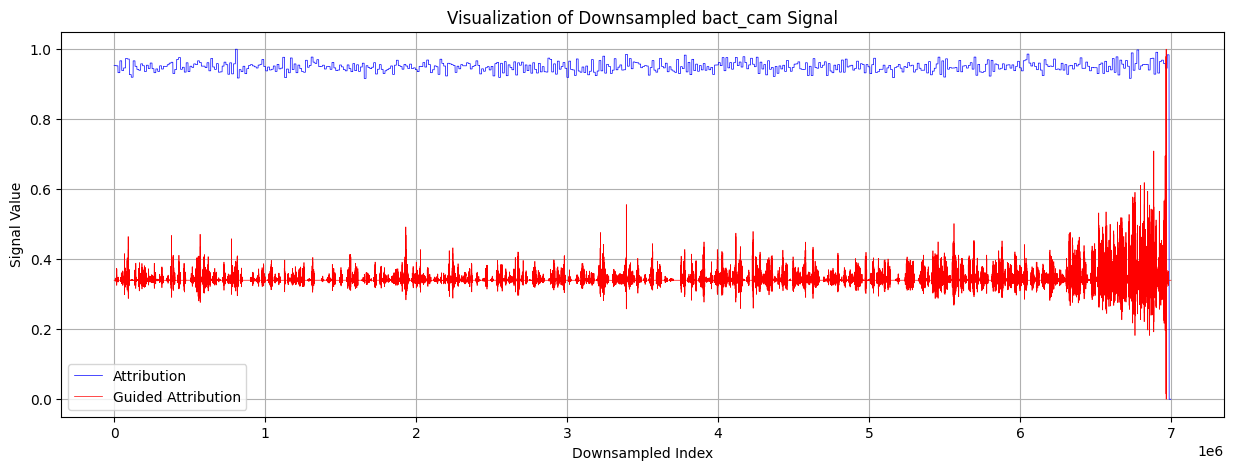

In [61]:
from scipy.signal import resample

import matplotlib.pyplot as plt

# Plot the downsampled signal
plt.figure(figsize=(15, 5))
plt.plot(attribution_scaled, lw=0.5, c='b')
plt.plot(attribution_guided_scaled, lw=0.5, c='r')
plt.title("Visualization of Downsampled bact_cam Signal")
plt.xlabel("Downsampled Index")
plt.ylabel("Signal Value")
plt.legend(["Attribution", "Guided Attribution"])
plt.grid(True)
plt.show()

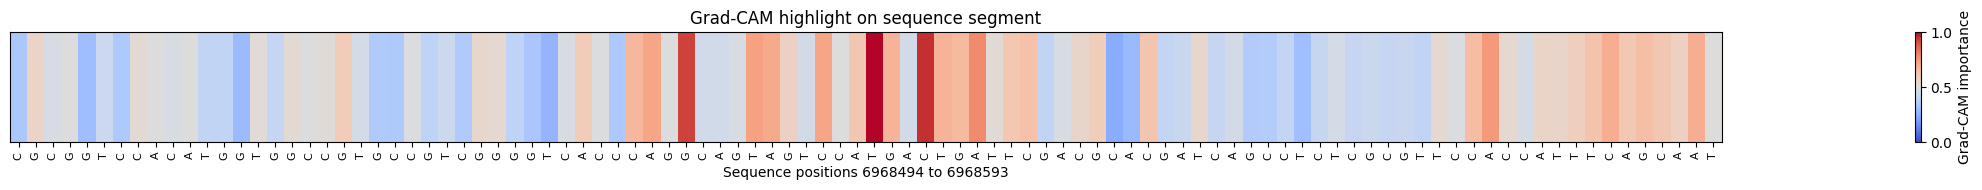

(<Figure size 2000x200 with 2 Axes>,
 <Axes: title={'center': 'Grad-CAM highlight on sequence segment'}, xlabel='Sequence positions 6968494 to 6968593'>)

In [79]:
plot_sequence_gradcam(bact_seq[:6988208], attribution_guided_scaled[:6988208])

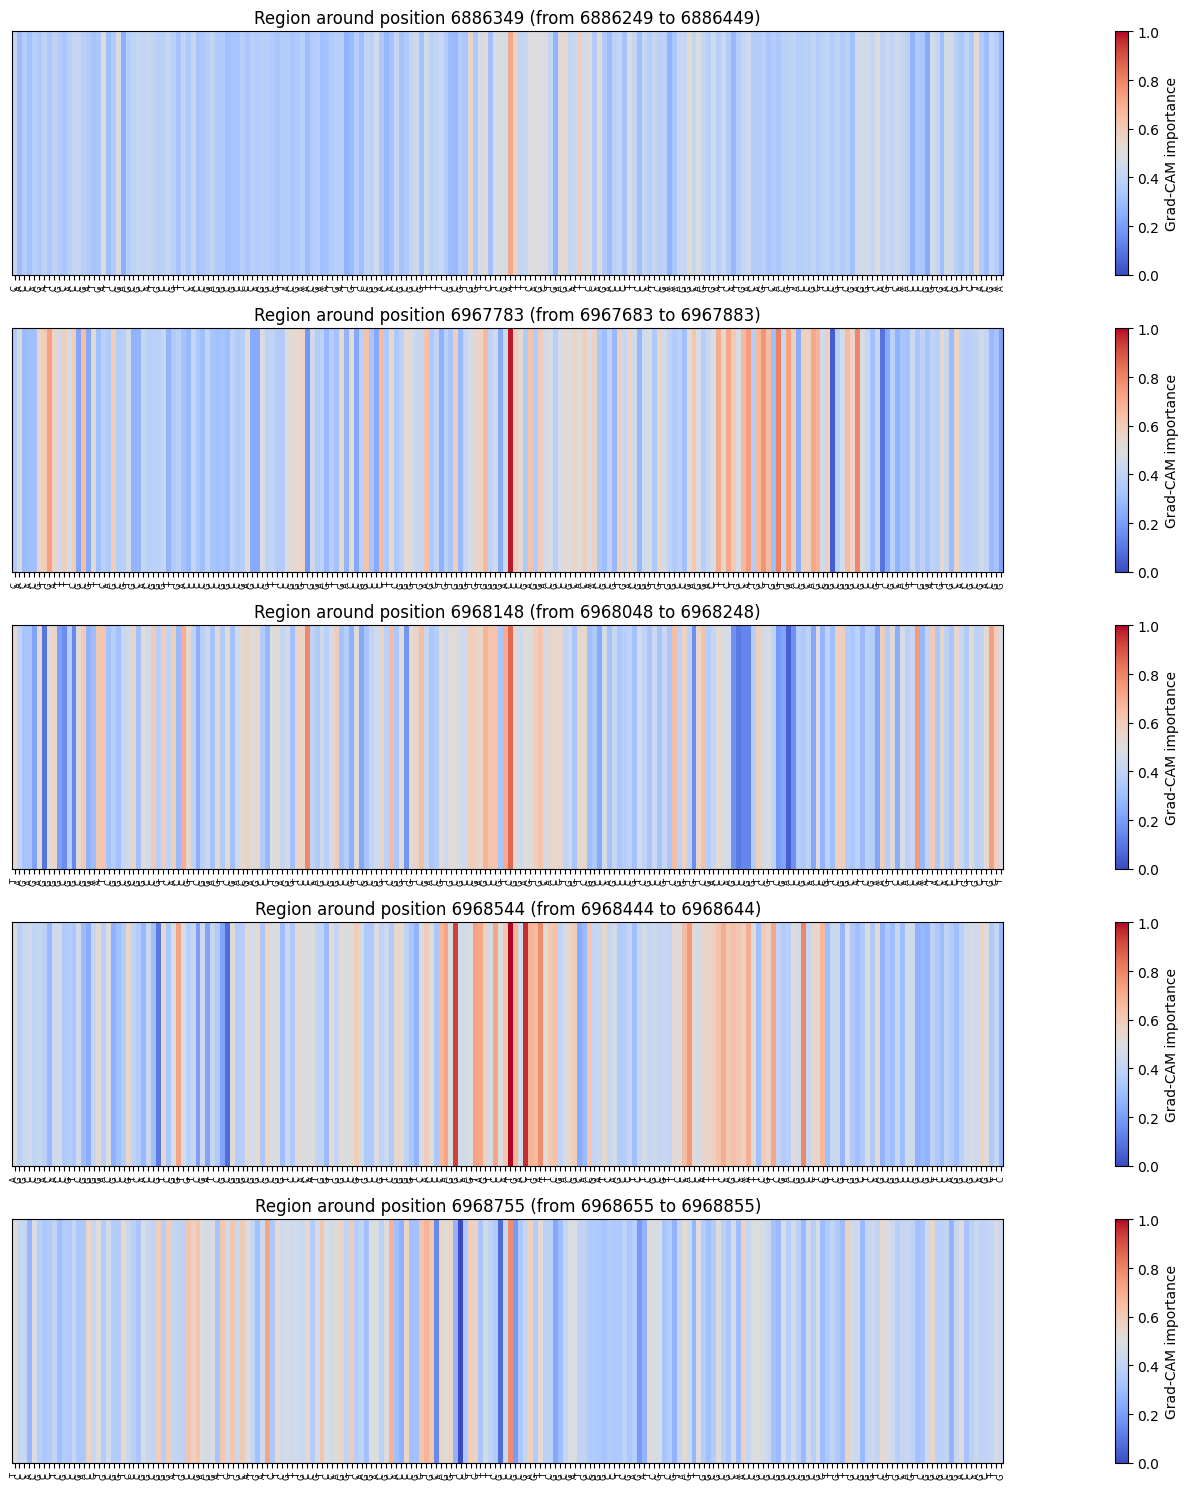

(<Figure size 1200x1500 with 10 Axes>,
 array([<Axes: title={'center': 'Region around position 6886349 (from 6886249 to 6886449)'}>,
        <Axes: title={'center': 'Region around position 6967783 (from 6967683 to 6967883)'}>,
        <Axes: title={'center': 'Region around position 6968148 (from 6968048 to 6968248)'}>,
        <Axes: title={'center': 'Region around position 6968544 (from 6968444 to 6968644)'}>,
        <Axes: title={'center': 'Region around position 6968755 (from 6968655 to 6968855)'}>],
       dtype=object))

In [80]:
plot_top_k_gradcam_regions(bact_seq[:6988208], attribution_guided_scaled[:6988208])

In [67]:
bacteria_df

,bacterium_id,bacterium_sequence,sequence_length
0,5859,TTGACTGCTGACCCCGACCCACCGTTCGTCGCCGTCTGGAACAGCG...,6988208
1,5787,GGCGCGGTCCTGACGGCACCGGCAGCCGACGCCGCTCCGAAGGAAG...,8409936
2,153,ATGACAGTAGACGAAGCCAACCACGCCAATACTGTCGGAAGTTCCT...,4434904
3,1869,CCCCGTGACTTCAGACCGAGACACTTTCGGCGAGGTGTGGCAGCAG...,5701501
4,126,CCGGTCGACGAGCGGGCTTGTCCCCTGCCGGGCTGGTGCTTCTGGT...,8226158
...,...,...,...
89,244,AGAGATTACGTCTGGTTGCAAGAGATCATGACAGGGGGAATTGGTT...,4857450
90,1053,GTGTCAGTGGAACTTTGGCAGCAGTGCGTGGAGCTTTTGCGCGATG...,6722539
91,586,TAATAGATGGATACTATGTTTTTTGGATTACCCACAGAAACCACAG...,1842899
92,799,TTGTTGATATTCTGTTTTTTCTTTTTTAGTTTTCCACATAAAAAAT...,1900521


In [72]:
bacteria_df[bacteria_df['bacterium_sequence'].str[:1000] == bact_seq[:1000]]

,bacterium_id,bacterium_sequence,sequence_length
0,5859,TTGACTGCTGACCCCGACCCACCGTTCGTCGCCGTCTGGAACAGCG...,6988208


In [78]:
phages_df[phages_df['phage_sequence'].str[:13000] == phage_seq[:13000]]

,phage_id,phage_sequence,sequence_length
124,2066,GAGGAGCACGAGCTGTGAGCTACGAACCGCCGGTCCGCGTCGAGAT...,154466


In [81]:
import numpy as np
import matplotlib.pyplot as plt

def find_top_k_important_windows(sequence, 
                                 combined_attribution, 
                                 k=5, 
                                 window_size=500):
    """
    Identify top k non-overlapping windows of fixed size based on mean Grad-CAM attribution.
    
    Parameters:
    -----------
    sequence : str
        The full DNA sequence (length N).
    combined_attribution : 1D np.array
        Grad-CAM attributions of length N.
    k : int
        Number of windows to retrieve.
    window_size : int
        Size of each window (bp).
    
    Returns:
    --------
    top_windows : list of tuples
        Each tuple contains (start_index, end_index, mean_attribution).
    """
    N = len(sequence)
    
    # Safety check
    if len(combined_attribution) != N:
        raise ValueError("Sequence and attribution must have the same length.")
    if window_size > N:
        raise ValueError("window_size cannot exceed the length of the sequence.")

    # 1. Compute mean attribution for each window using convolution
    # sums[i] will be sum of attributions in the window [i, i+window_size-1]
    # means will be sums / window_size
    sums = np.convolve(combined_attribution, np.ones(window_size, dtype=np.float32), mode='valid')
    means = sums / window_size  # shape: (N - window_size + 1,)

    # 2. Find indices that give the highest mean attribution
    # Sort window start indices by descending mean
    sorted_indices = np.argsort(means)[::-1]

    # 3. Pick top k non-overlapping windows
    selected_indices = []
    top_windows = []
    for idx in sorted_indices:
        # window range is [idx, idx + window_size)
        # check overlap with already selected windows
        overlap = False
        for (start_sel, end_sel, _) in top_windows:
            if not (idx + window_size <= start_sel or idx >= end_sel):
                # They overlap
                overlap = True
                break

        if not overlap:
            window_mean = means[idx]
            top_windows.append((idx, idx + window_size, window_mean))

        if len(top_windows) == k:
            break

    # Sort the final windows by their start index
    top_windows.sort(key=lambda x: x[0])
    return top_windows


def plot_top_windows(sequence, combined_attribution, top_windows):
    """
    Plot the attribution heatmaps for each selected window.

    Parameters:
    -----------
    sequence : str
        Full DNA sequence.
    combined_attribution : 1D np.array
        Grad-CAM attributions, length = len(sequence).
    top_windows : list of tuples
        (start, end, mean_val) for each window.
    """
    n = len(top_windows)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n))
    if n == 1:
        axs = [axs]  # ensure iterable

    for ax, (start, end, mean_val) in zip(axs, top_windows):
        region_seq = sequence[start:end]
        region_attr = combined_attribution[start:end]
        
        heatmap = region_attr[np.newaxis, :]  # shape (1, window_size)
        im = ax.imshow(heatmap, aspect='auto', cmap='coolwarm')
        
        ax.set_xticks(np.arange(len(region_seq)))
        ax.set_xticklabels(list(region_seq), fontsize=6, rotation=90)
        ax.set_yticks([])
        ax.set_title(f"Window {start}-{end}, Mean Attribution={mean_val:.4f}")
        
        # colorbar
        fig.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')

    plt.tight_layout()
    plt.show()
    return fig, axs


In [84]:
top_windows = find_top_k_important_windows(bact_seq, attribution_guided_scaled, 5, 500)

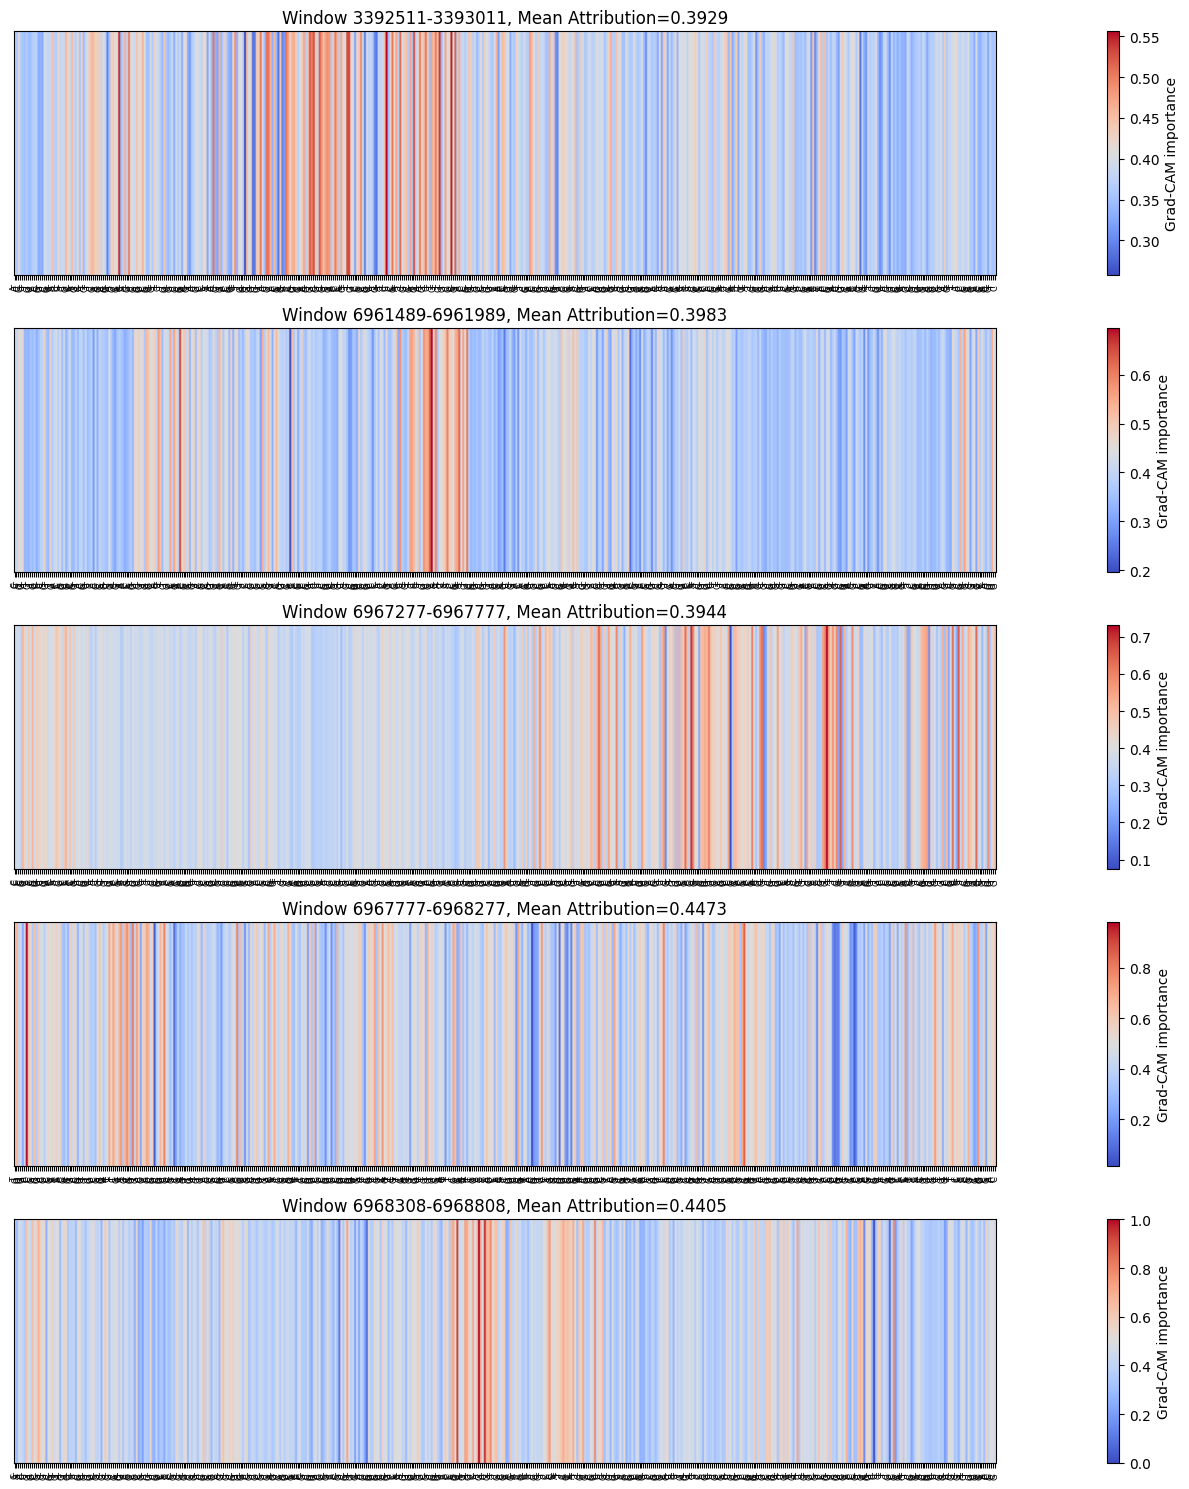

(<Figure size 1200x1500 with 10 Axes>,
 array([<Axes: title={'center': 'Window 3392511-3393011, Mean Attribution=0.3929'}>,
        <Axes: title={'center': 'Window 6961489-6961989, Mean Attribution=0.3983'}>,
        <Axes: title={'center': 'Window 6967277-6967777, Mean Attribution=0.3944'}>,
        <Axes: title={'center': 'Window 6967777-6968277, Mean Attribution=0.4473'}>,
        <Axes: title={'center': 'Window 6968308-6968808, Mean Attribution=0.4405'}>],
       dtype=object))

In [85]:
plot_top_windows(bact_seq, attribution_guided_scaled, top_windows)

In [89]:
window_start, window_end, mean_val = top_windows[1] 
subseq = bact_seq[window_start:window_end]


In [90]:
subseq

'CCTGGATGTAGCCCTGGTTGACCAGGCGCCGGTACGGCTCACGCGAGCTGACGTAACCCAGGTCGTAGAGCACCTTGTGCCAGAACCGCGAGTACAGCAGGTGCAGCACAGCGTGTTCCACGCCGCCGACGTACAGGTCGACACCGCCCGGATCCTCCGGGCCGTGCTCGTCGGGGCGCGGCCCCATCCAGTACGCCTCGTTCTCCTTGGCGCACATCTCATCCGGATTGTGCGGGTCGGTGTAGCGCAGCTCGTACCACGAGCTGCCGGCCCACTGCGGCATGACATTGGTGTCACGCGTGTAGGACTGCAGACCGTCACCGAGGTCGAGTTCGACGTGGACCCATTCGGTGGCCTTGTTCAGCGGCGGCGAGGGCTCGCTGTCGGCGTCGTCCGGGTCGAACAGCACCGGCGAGTAGTCGGGAACGTCCGGAAGCTCAACGGGCAGAGCAGATTCCGGCAGCGGGTGGGCACGTCCGTCGGCGTCGTAGACAATGGGG'

In [91]:
# Define a function to write this to a FASTA file
def write_fasta(seq, filename, seq_id="my_sequence"):
    with open(filename, "w") as f:
        f.write(f">{seq_id}\n")  # fasta header
        f.write(seq + "\n")       # actual sequence

write_fasta(subseq, "subseq2.fasta", seq_id="Seq1")
print("FASTA file created: subseq2.fasta")

FASTA file created: subseq2.fasta
